In [1]:
import pandas as pd

df = pd.read_csv('/content/synthetic_hr_rpe_dataset.csv')
print(df.shape)
df.head()


(320, 12)


,timestamp,session_id,exercise_type,set_number,avg_bpm,peak_bpm,min_bpm_rest,hr_recovery_30s,recovery_slope,hr_variability,session_load_index,rpe_label
0,2025-11-10T18:10:00,7,lateral_raise,3,122.7,134,102,27,-1.067,3.088,0.261,5
1,2025-11-11T03:39:00,2,lateral_raise,2,105.3,115,100,15,-0.500,5.605,0.142,4
2,2025-11-11T02:00:00,16,deadlift,3,147.4,159,133,26,-0.867,3.173,0.176,8
3,2025-11-11T15:31:00,14,shoulder_press,1,126.7,140,115,24,-0.833,2.568,0.197,6
4,2025-11-11T13:34:00,2,squat,2,131.9,148,130,12,-0.600,4.007,0.136,9


In [3]:
!pip install -q tensorflow scikit-learn matplotlib



Test Train split

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Choose features that come from the data
features = [
    'avg_bpm',
    'peak_bpm',
    'min_bpm_rest',
    'hr_recovery_30s',
    'recovery_slope',
    'hr_variability',
    'session_load_index'
]

# Define X (input features) and y (target RPE label)
X = df[features]
y = df['rpe_label'].astype(float)

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# Standardize (normalize) data for stable training
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)

print("✅ Data split complete.")
print("Training samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])


✅ Data split complete.
Training samples: 272
Test samples: 48


Creating four models of diffrent sizes to choose the best

In [9]:
import tensorflow as tf
from sklearn.metrics import r2_score

tf.random.set_seed(42)

# Helper function to train and evaluate any model
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def train_and_eval(model_fn, name):
    model = model_fn()
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    es = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True
    )
    model.fit(
        X_train_s, y_train,
        validation_split=0.1,
        epochs=120, batch_size=16, verbose=0,
        callbacks=[es]
    )

    # Predictions
    y_pred = model.predict(X_test_s).flatten()

    # Compute metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_pred)

    print(f"{name:25s} | MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f} | MAPE={mape:.2f}%")

    return model, mae, rmse, r2, mape



# --- Model 1: Small dense network ---
def dense_small():
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train_s.shape[1],)),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1)
    ])


# --- Model 2: Medium dense network ---
def dense_medium():
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train_s.shape[1],)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1)
    ])


# --- Model 3: Regularized network with dropout ---
def dropout_reg():
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train_s.shape[1],)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1)
    ])


# --- Model 4: Linear baseline (simple regression) ---
def linear_baseline():
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train_s.shape[1],)),
        tf.keras.layers.Dense(1)
    ])


Train and evaluate all the models

In [10]:
models = [dense_small, dense_medium, dropout_reg, linear_baseline]
results = []

for model_fn in models:
    print("\n==============================")
    print("Training model:", model_fn.__name__)
    print("==============================")
    model, mae, rmse, r2, mape = train_and_eval(model_fn, model_fn.__name__)
    results.append((model_fn.__name__, mae, rmse, r2, mape, model))

print("\n✅ Training complete for all models!")



Training model: dense_small
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
dense_small               | MAE=0.592 | RMSE=0.741 | R²=0.914 | MAPE=13.27%

Training model: dense_medium
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
dense_medium              | MAE=0.611 | RMSE=0.723 | R²=0.918 | MAPE=13.91%

Training model: dropout_reg
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
dropout_reg               | MAE=0.574 | RMSE=0.714 | R²=0.920 | MAPE=12.60%

Training model: linear_baseline
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
linear_baseline           | MAE=4.466 | RMSE=4.568 | R²=-2.253 | MAPE=95.22%

✅ Training complete for all models!


✅ Best model selected: dropout_reg
MAE=0.574, RMSE=0.714, R²=0.920, MAPE=12.60%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of labels (11).

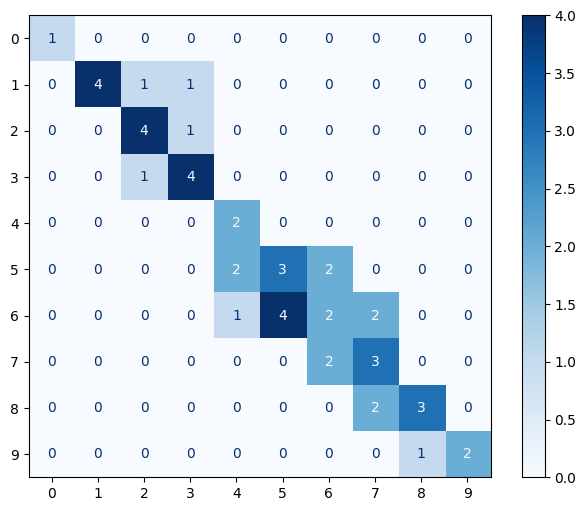

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# ✅ Step 1: Pick best model (lowest MAE)
best_entry = sorted(results, key=lambda x: x[1])[0]  # x[1] = MAE
best_name, best_mae, best_rmse, best_r2, best_mape, best_model = best_entry
print(f"✅ Best model selected: {best_name}")
print(f"MAE={best_mae:.3f}, RMSE={best_rmse:.3f}, R²={best_r2:.3f}, MAPE={best_mape:.2f}%")

# ✅ Step 2: Predict on test data
y_pred = best_model.predict(X_test_s).flatten()

# Round continuous predictions to nearest integer (for confusion matrix)
y_pred_rounded = np.clip(np.round(y_pred), 0, 10).astype(int)
y_true_rounded = np.clip(np.round(y_test), 0, 10).astype(int)

# ✅ Step 3: Generate confusion matrix
cm = confusion_matrix(y_true_rounded, y_pred_rounded)

# Display matrix with labels 0–10
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(0, 11))

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', colorbar=True)
plt.title(f"Confusion Matrix for Best Model ({best_name})")
plt.show()


In [12]:
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    explained_variance_score, median_absolute_error, max_error,
    accuracy_score, precision_score, recall_score, f1_score, classification_report
)
import numpy as np

# Ensure predictions are available
y_pred = best_model.predict(X_test_s).flatten()

# ✅ Regression metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)
median_ae = median_absolute_error(y_test, y_pred)
max_err = max_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
corr = np.corrcoef(y_test, y_pred)[0, 1]

# ✅ Classification-style metrics (rounded predictions)
y_pred_rounded = np.clip(np.round(y_pred), 0, 10).astype(int)
y_true_rounded = np.clip(np.round(y_test), 0, 10).astype(int)

accuracy = accuracy_score(y_true_rounded, y_pred_rounded)
precision = precision_score(y_true_rounded, y_pred_rounded, average='weighted', zero_division=0)
recall = recall_score(y_true_rounded, y_pred_rounded, average='weighted', zero_division=0)
f1 = f1_score(y_true_rounded, y_pred_rounded, average='weighted', zero_division=0)

# ✅ Print results
print("📊 EXTENDED MODEL EVALUATION METRICS\n")
print("----- Regression Metrics -----")
print(f"Mean Absolute Error (MAE):        {mae:.4f}")
print(f"Root Mean Squared Error (RMSE):   {rmse:.4f}")
print(f"R² Score:                         {r2:.4f}")
print(f"Explained Variance:               {explained_var:.4f}")
print(f"Median Absolute Error:            {median_ae:.4f}")
print(f"Maximum Error:                    {max_err:.4f}")
print(f"Mean Absolute Percentage Error:   {mape:.2f}%")
print(f"Correlation (True vs Predicted):  {corr:.4f}")

print("\n----- Classification-style Metrics -----")
print(f"Accuracy : {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall   : {recall*100:.2f}%")
print(f"F1 Score : {f1*100:.2f}%")

# Optional: class-level breakdown
print("\nClassification Report:\n")
print(classification_report(y_true_rounded, y_pred_rounded, zero_division=0))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
📊 EXTENDED MODEL EVALUATION METRICS

----- Regression Metrics -----
Mean Absolute Error (MAE):        0.5736
Root Mean Squared Error (RMSE):   0.7145
R² Score:                         0.9204
Explained Variance:               0.9226
Median Absolute Error:            0.3804
Maximum Error:                    1.6182
Mean Absolute Percentage Error:   12.60%
Correlation (True vs Predicted):  0.9610

----- Classification-style Metrics -----
Accuracy : 58.33%
Precision: 61.17%
Recall   : 58.33%
F1 Score : 58.02%

Classification Report:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       1.00      0.67      0.80         6
           3       0.67      0.80      0.73         5
           4       0.67      0.80      0.73         5
           5       0.40      1.00      0.57         2
           6       0.43      0.43      0.43         7
           7       0.33      0.22      0.27     

Quantizing the model for deployment

In [13]:
import tensorflow as tf

# ✅ Convert the best Keras model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)

# Apply optimizations for size and speed (important for ESP32)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Quantize weights to 8-bit integers
tflite_quant_model = converter.convert()

# Save the quantized model
with open("rpe_model_quant.tflite", "wb") as f:
    f.write(tflite_quant_model)

print("✅ Quantized TFLite model saved as rpe_model_quant.tflite")


Saved artifact at '/tmp/tmpvbdgmd9y'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 7), dtype=tf.float32, name='keras_tensor_29')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138734782428176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138734782420688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138734782420496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138734782419344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138734782419152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138734782419536: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Quantized TFLite model saved as rpe_model_quant.tflite


Testing quantized model

In [15]:
import numpy as np

# Load quantized model
interpreter = tf.lite.Interpreter(model_path="rpe_model_quant.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test prediction on a few samples
for i in range(3):
    test_sample = X_test_s[i:i+1].astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], test_sample)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])

    print(f"Sample {i+1}: True RPE={y_test[i]:.2f}, Predicted (Quantized)={output[0][0]:.2f}")


Sample 1: True RPE=3.00, Predicted (Quantized)=3.20
Sample 2: True RPE=2.00, Predicted (Quantized)=2.39
Sample 3: True RPE=10.00, Predicted (Quantized)=9.95


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Convert to C for firmware

In [16]:
# Convert TFLite file to a C header file
!xxd -i rpe_model_quant.tflite > rpe_model_quant.h

# Rename variable for clarity
!sed -i 's/rpe_model_quant_tflite/rpe_model/g' rpe_model_quant.h

print("✅ Model successfully converted to rpe_model_quant.h (C array for ESP32)")


✅ Model successfully converted to rpe_model_quant.h (C array for ESP32)
